# Map

In this notebook I build a map. For this, I use [folium](https://github.com/python-visualization/folium) library.
Also, I use my own implementation of Kruskal's algorithm of building a minimum spanning tree, in order to obtain edges a.k.a. 'roads'. 

Besides, I will compare real total distance of roads with the one I obtained. To get the real distances, I use [googlemaps](https://github.com/googlemaps/google-maps-services-python) directions API.

In [1]:
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
import folium
import time
import googlemaps
import matplotlib.pyplot as plt
import networkx as nx
import re
%matplotlib inline

from folium.plugins import MarkerCluster
from algos.mst import kruskal_mst

Importing data

In [3]:
cities_df = pd.read_csv('./data/cities_data_ukraine_clean.csv', 
                        index_col=0)

cities_df = cities_df.set_index('city')

cities_df.head()

,lat,long
city,,
Kyiv,50.450034,30.524136
Kharkiv,49.990279,36.230389
Odessa,46.485242,30.743389
Dnipro,51.920749,30.824980
Donetsk,48.015875,37.801341


In [4]:
adj_matrix = pd.read_csv('./data/adj_matrix.csv')
adj_matrix = adj_matrix.set_index('city')

adj_matrix.head()

,Kyiv,Kharkiv,Odessa,Dnipro,Donetsk,Zaporizhia,Lviv,Kryvyi Rih,Mykolaiv,Mariupol,...,Hlyniany,Pidhaitsi,Baturyn,Belz,Ustyluh,Hertsa,Berestechko,Uhniv,Chernobyl,Prypiat
city,,,,,,,,,,,,,,,,,,,,,
Kyiv,0.000000,408.084724,440.161029,163.874607,592.319500,440.643460,466.401893,349.941788,401.314189,633.794157,...,432.709372,406.870995,191.637638,353.558793,450.495101,400.213093,381.982537,479.180016,92.707584,110.236624
Kharkiv,408.084724,0.000000,561.779265,434.075751,246.638023,250.387917,871.614632,309.535481,457.298545,332.309876,...,837.231609,801.334992,277.297722,655.613396,859.221957,753.035718,790.479193,887.860804,446.078343,461.243440
Odessa,440.161029,561.779265,0.000000,603.430581,558.010222,362.844938,620.792366,254.212395,108.917659,523.976097,...,591.146964,518.999680,559.803357,255.796823,684.946570,384.364458,596.700183,671.423538,532.473907,548.461428
Dnipro,163.874607,434.075751,603.430581,0.000000,659.915521,545.981965,528.413441,481.252783,556.481443,720.619957,...,499.178430,497.016883,156.219756,506.696318,476.641720,529.959113,433.052603,521.838479,82.528497,76.970215
Donetsk,592.319500,246.638023,558.010222,659.915521,0.000000,199.718706,1023.673730,327.489609,449.872183,99.058853,...,988.863018,938.767643,509.059105,736.508187,1033.752290,855.772502,955.317562,1051.478762,653.479063,670.891805


In [5]:
G = nx.from_pandas_adjacency(adj_matrix)

In [6]:
T = kruskal_mst(G)

In [7]:
list(T.edges)[:5]

[('Kyiv', 'Vyshneve'),
 ('Kyiv', 'Vyshhorod'),
 ('Kyiv', 'Brovary'),
 ('Kharkiv', 'Oleshky'),
 ('Kharkiv', 'Derhachi')]

## Draw a map
In this section I draw a map and count the distance of direct roads (not the actual distance of roads yet). Besides, as a tooltip for a road I use its lenght. 

In [126]:
coord_start = [48.640493, 31.634205] 

my_map = folium.Map(location=coord_start, zoom_start= 6)

marker_clust = MarkerCluster().add_to(my_map)
for i, city in enumerate(cities_df.index):
    coord = cities_df['lat'][i], cities_df['long'][i] 
    folium.Marker(location=coord, popup=city, icon=folium.Icon(color='gray')).add_to(marker_clust)

folium.TileLayer('cartodbdark_matter').add_to(my_map)
folium.LayerControl().add_to(my_map)

total_length = 0
for orig, dest, length in list(T.edges.data('weight')):
    coord1 = cities_df['lat'][orig], cities_df['long'][orig]
    coord2 = cities_df['lat'][dest], cities_df['long'][dest]
    tooltip = length
    line = [coord1, coord2]
    total_length += length
    
    folium.PolyLine(locations=line, weight=5, \
                    color='yellow', tooltip="length (km): " + str(round(tooltip, ndigits=2)))\
                    .add_to(my_map)
    
my_map

In [177]:
# my_map.save('map.html')

In [127]:
total_length

10673.421757980615

In [5]:
total_length = 10673.421757980615

## Actual length
Here I format coordinates to match googlemaps API requirements and use regular expression to find a number in the resulting string. 

In [ ]:
gmaps = googlemaps.Client(key='__here is your API key__')

In [165]:
act_length = 0
for orig, dest, length in list(T.edges.data('weight')):
    coord1 = cities_df['lat'][orig], cities_df['long'][orig]
    coord2 = cities_df['lat'][dest], cities_df['long'][dest]
    ans = gmaps.directions(coord1, coord2)
    
    m = re.search('(^[0-9]*)', ans[0]['legs'][0]['distance']['text'])
    act_length += int(m.group(0))
    
    time.sleep(0.2)

In [166]:
act_length

15658

In [6]:
act_length = 15658

## A bit of visualization!

Let us compare an actual distance between cities and a "straight line" ditance. For this, draw a barchart and label the numbers we got on it.

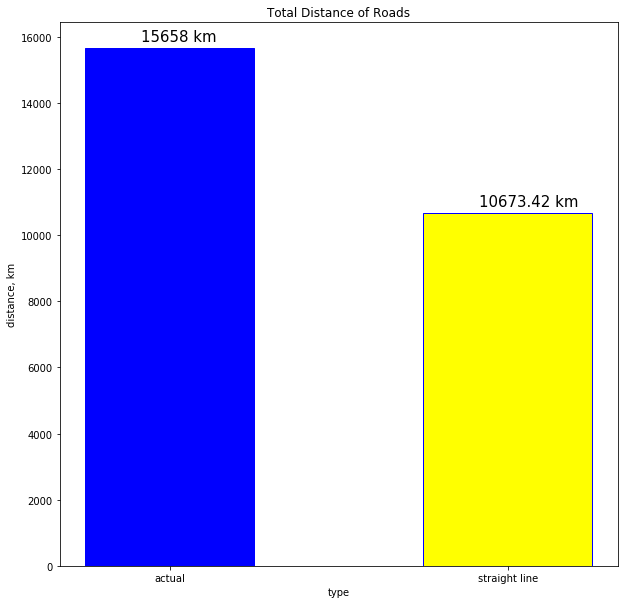

In [50]:
plt.figure(figsize=(10,10))
plt.ylabel('distance, km')
plt.xlabel('type')
plt.title('Total Distance of Roads')
plt.bar(x=['actual', 'straight line'], height=[act_length, total_length], 
        width=0.5, color=['blue', 'yellow'], edgecolor='b')

for i, v in enumerate([act_length, total_length]):
    plt.text(i - 0.085, v + 200, str(round(v, 2)) + ' km', color='black', fontsize=15)

Not much of a surprise, the straight line distance is less than the actual one. It may be caused by some terrain obstacles that are not counted by a "straight line method".